In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, AvgPool2D  , Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint , History
from tensorflow.keras.optimizers import Adam, Nadam

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

image_directory = '/content/drive/MyDrive/garbage-dataset_balanceado'

# Create the ImageDataGenerator for training set with data augmentation
train_data_generator = ImageDataGenerator( rescale=1./255.,
                                           rotation_range=20,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           horizontal_flip=True,
                                           shear_range = 0.1,
                                           zoom_range  = 0.3,
                                           validation_split=0.2)

# Create the ImageDataGenerator for validation set without data augmentation
val_data_generator = ImageDataGenerator(rescale=1./255. , validation_split=0.2)

batch_size=32


train_generator = train_data_generator.flow_from_directory(
    directory=image_directory,
    target_size=(180, 180),
    color_mode='rgb',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=True,
    subset='training',
)

val_generator = val_data_generator.flow_from_directory(
    directory=image_directory,
    target_size=(180, 180),
    color_mode='rgb',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    subset='validation',
)

class_indices= train_generator.class_indices
with open('class_indices.pkl', 'wb') as f:
    pickle.dump(class_indices, f)


Found 5600 images belonging to 5 classes.
Found 1400 images belonging to 5 classes.


In [ ]:
# Split the data_generator into training and validation sets
# Use __next__() instead of next()
X_train, y_train = train_generator.__next__()
X_val, y_val = val_generator.__next__()

print()
print(f"train_generator.samples= {train_generator.samples}")
print(f"train_generator.samples// batch_size={train_generator.samples// batch_size}")
print(f"len(train_generator)={len(train_generator)}")
print(f"len(X_train)={len(X_train)}")



train_generator.samples= 5600
train_generator.samples// batch_size=175
len(train_generator)=175
len(X_train)=32


In [ ]:
model = Sequential([
Conv2D(32, (5, 5), activation='relu', input_shape=(180, 180, 3)),
MaxPool2D(pool_size=(2, 2)),
Conv2D(32, (5, 5), activation='relu'),
MaxPool2D(pool_size=(2, 2)),
Conv2D(64, (3, 3), activation='relu'),
MaxPool2D(pool_size=(2, 2)),
Conv2D(64, (3, 3), activation='relu'),
MaxPool2D(pool_size=(2, 2)),
Flatten(),
Dense(128, activation='relu'),
Dense(64, activation='relu'),
Dense(32, activation='relu'),
Dropout(0.2),
Dense(16, activation='relu'),
Dropout(0.2),
Dense(5, activation='softmax')])

#plot_model(model, show_shapes=True, show_layer_names=False)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 176, 176, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 88, 88, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 84, 84, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 42, 42, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 40, 40, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         663,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 758,117 (2.89 MB)

 Trainable params: 758,117 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')

In [ ]:
class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.best_val_accuracy = -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs.get('val_accuracy')

        if current_val_accuracy and current_val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = current_val_accuracy
            print(f" Modelo guardado época {epoch + 1} con exactitud: {current_val_accuracy:.4f}")

        super().on_epoch_end(epoch, logs)

# Define la ruta en Google Drive
model_save_path = '/content/drive/MyDrive/modelos_guardados/'

# Crea la carpeta si no existe
os.makedirs(model_save_path, exist_ok=True)

# Ruta completa en Google Drive
save_filepath = os.path.join(model_save_path, 'cnn4.keras')

# Inicializar el callback personalizado con la nueva ruta
custom_model_checkpoint = CustomModelCheckpoint(
    filepath=save_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

In [ ]:
epochs = 20
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping, custom_model_checkpoint]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


174/175 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.2287 - loss: 1.6032 Modelo guardado época 1 con exactitud: 0.1986

Epoch 1: val_accuracy improved from -inf to 0.19857, saving model to /content/drive/MyDrive/modelos_guardados/best_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 2838s 16s/step - accuracy: 0.2289 - loss: 1.6030 - val_accuracy: 0.1986 - val_loss: 1.5843
Epoch 2/20
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.2755 - loss: 1.5703 Modelo guardado época 2 con exactitud: 0.4643

Epoch 2: val_accuracy improved from 0.19857 to 0.46429, saving model to /content/drive/MyDrive/modelos_guardados/best_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 102s 524ms/step - accuracy: 0.2760 - loss: 1.5699 - val_accuracy: 0.4643 - val_loss: 1.3226
Epoch 3/20
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.4020 - loss: 1.4080
Epoch 3: val_accuracy did not improve from 0.46429
175/175 ━━━━━━━━━━━━━━━━━━━━ 92s 508ms/step - accuracy: 0.4021 - loss: 1.4080 - val_accuracy: 0.4443 - va

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step


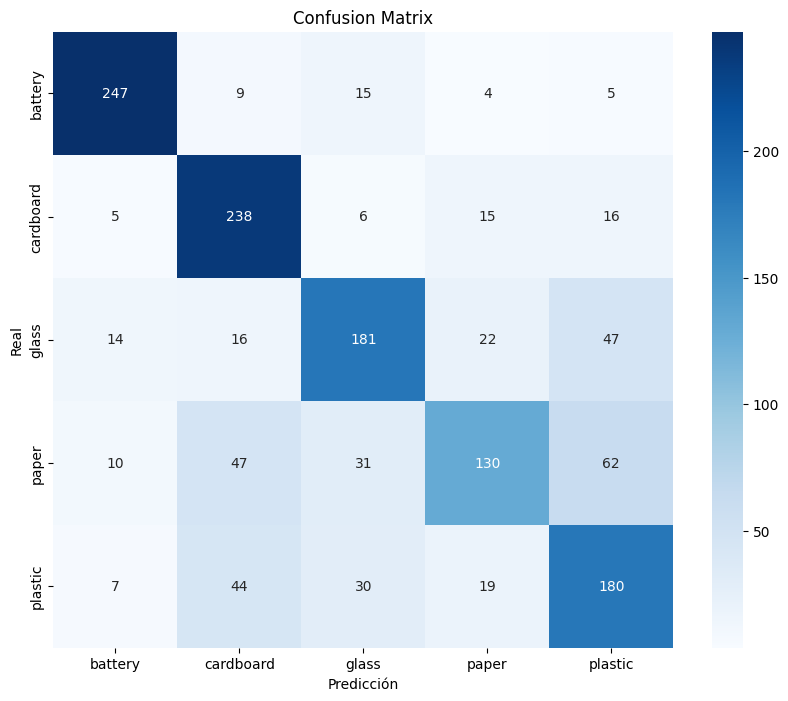

              precision    recall  f1-score   support

     battery       0.87      0.88      0.88       280
   cardboard       0.67      0.85      0.75       280
       glass       0.69      0.65      0.67       280
       paper       0.68      0.46      0.55       280
     plastic       0.58      0.64      0.61       280

    accuracy                           0.70      1400
   macro avg       0.70      0.70      0.69      1400
weighted avg       0.70      0.70      0.69      1400



In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import numpy as np

best_model = load_model('/content/drive/MyDrive/modelos_guardados/cnn4.keras')

#

y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir las probabilidades en clases

# 2. Obtener las etiquetas reales
y_true = val_generator.classes  # Clases verdaderas de los datos de validación

# 3. Crear la matriz de confusión
conf_matrix= confusion_matrix(y_true, y_pred_classes)

# predictions = best_model.predict(X_val) #X_val may not contain all labels
# predicted_classes = np.argmax(predictions, axis=1)

# conf_matrix = confusion_matrix(y_val, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            #xticklabels=np.unique(y_val), #y_val may not contain all labels
            #yticklabels=np.unique(y_val) #y_val may not contain all labels
            xticklabels=val_generator.class_indices,
            yticklabels=val_generator.class_indices
           )
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

#print(classification_report(y_val, predicted_classes, target_names=np.unique(y_val.astype(str))))
print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices)) #y_true and val_generator.class_indices should contain all labels

In [ ]:
best_val_accuracy = max(history.history['val_accuracy'])
print("val_categorical_accuracy:", best_val_accuracy)

val_categorical_accuracy: 0.6971428394317627


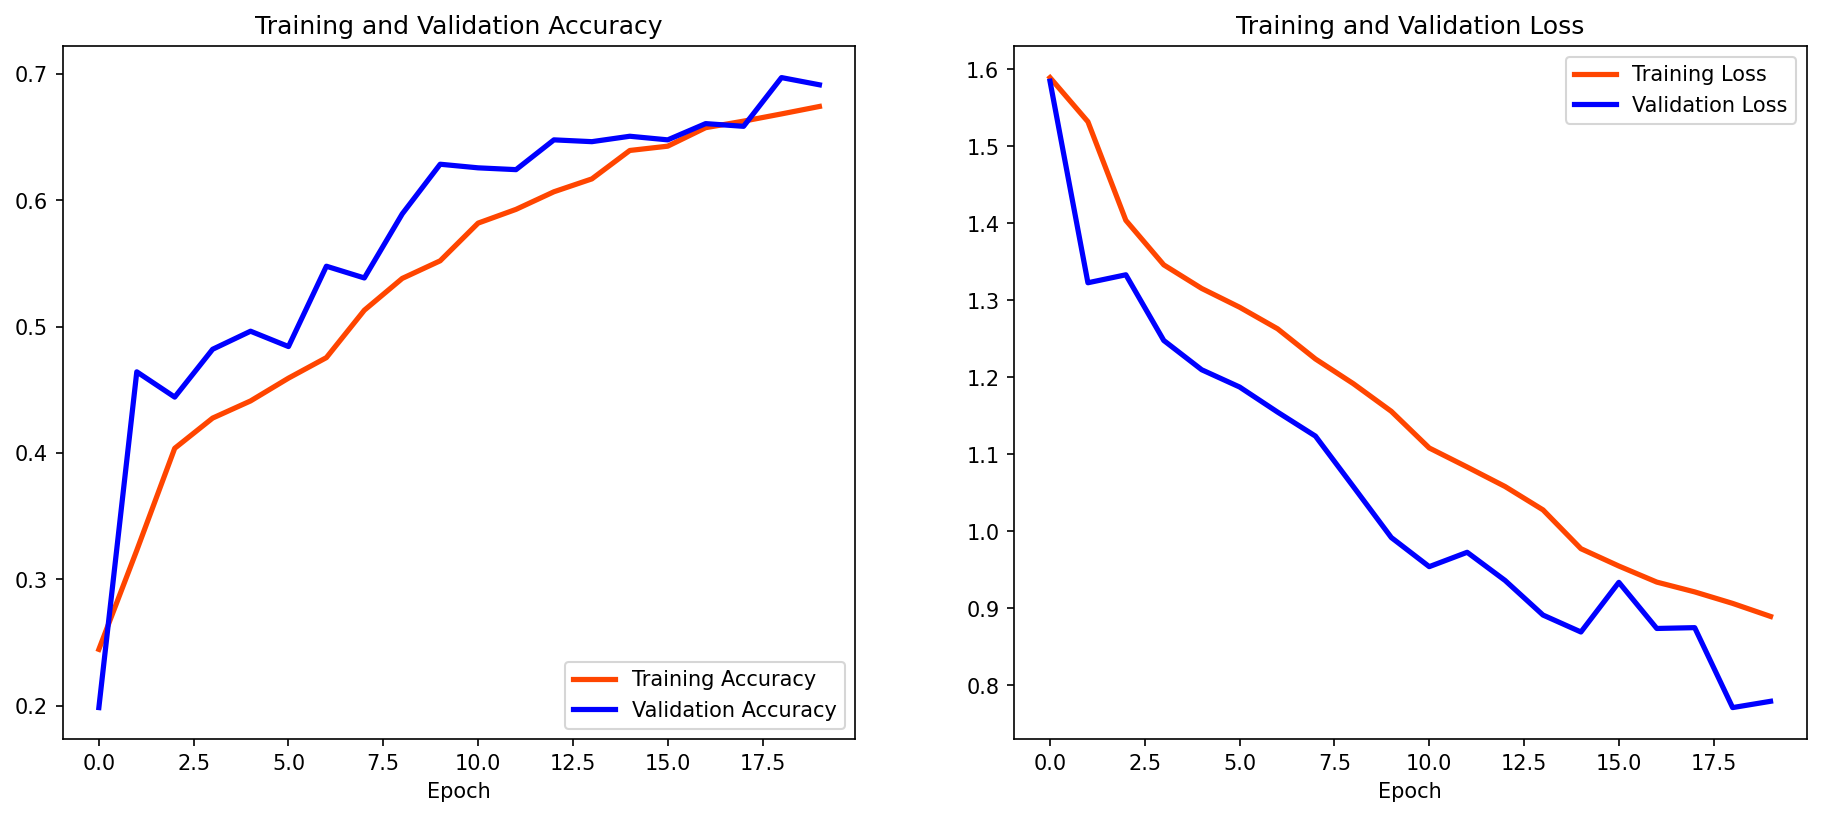

In [ ]:
# #Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# #loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# #epochs
epochs_range = range(len(history.epoch))
# #Plotting graphs
plt.figure(figsize=(15, 6), dpi=150)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy',color= 'orangered', linewidth = '2.5')
plt.plot(epochs_range, val_acc, label='Validation Accuracy',color= 'blue', linewidth = '2.5')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss',color= 'orangered', linewidth = '2.5')
plt.plot(epochs_range, val_loss, label='Validation Loss',color= 'blue', linewidth = '2.5')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# Importar modelo guardado
from tensorflow.keras.models import load_model
import os

model_save_path = '/content/drive/MyDrive/modelos_guardados/'

# Ruta del modelo guardado
saved_model_path = os.path.join(model_save_path, 'cnn4.keras')

# Cargar el modelo
loaded_model = load_model(saved_model_path)
print("Modelo cargado correctamente.")

Modelo cargado correctamente.


Found 100 images belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 394ms/step


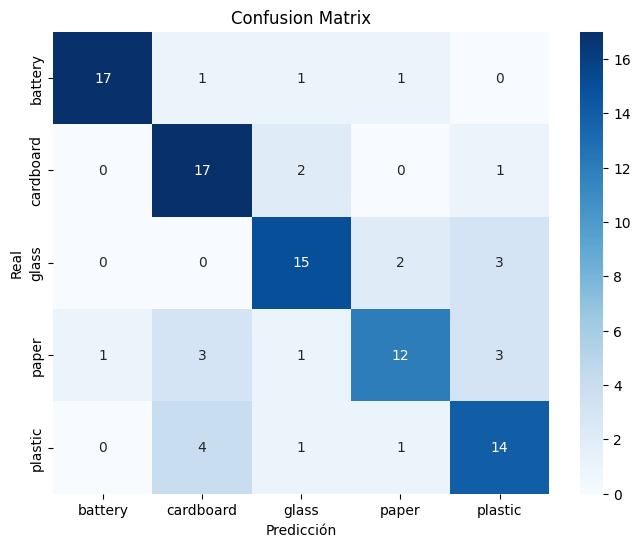

              precision    recall  f1-score   support

     battery       0.94      0.85      0.89        20
   cardboard       0.68      0.85      0.76        20
       glass       0.75      0.75      0.75        20
       paper       0.75      0.60      0.67        20
     plastic       0.67      0.70      0.68        20

    accuracy                           0.75       100
   macro avg       0.76      0.75      0.75       100
weighted avg       0.76      0.75      0.75       100

Accuracy: 0.7500


In [ ]:
# Prueba con dataset estandarizado de 100 imágenes
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import seaborn as sns
import numpy as np


# Define la ruta a las imágenes de prueba en Google Drive
test_dir = '/content/drive/MyDrive/dataset_prueba_final'

# Configura el generador de datos
test_datagen = ImageDataGenerator(rescale=1./255)

# Crea el generador
test_generator = test_datagen.flow_from_directory(
    test_dir,               # Directorio que contiene las imágenes
    target_size=(180, 180), # Tamaño de las imágenes (ajústalo al tamaño esperado por tu modelo)
    color_mode='rgb',
    class_mode='sparse',
    batch_size=32,          # Tamaño del batch
    shuffle=False           # No mezclar, importante para evaluar correctamente
)

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir las probabilidades en clases

# Obtener las etiquetas verdaderas
y_true = test_generator.classes  # Clases reales

# Crear la matriz de confusión
conf_matrix= confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices
           )
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices)) #y_true and val_generator.class_indices should contain all labels

# Accuracy
accuracy_test = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy_test:.4f}")